In [2]:
import glob
import os
import random

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from albumentations.pytorch import ToTensorV2
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm

## Dataset Stats

In [ ]:
def calculate_dataset_stats(dataset_dir):
    sum_r = sum_g = sum_b = 0.0
    sum_sq_r = sum_sq_g = sum_sq_b = 0.0
    total_pixels = 0
    processed_files = 0
    problematic_files = []

    total_images = 0
    for class_dir in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_dir)
        if os.path.isdir(class_path):
            total_images += len([f for f in os.listdir(class_path) 
                               if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    with tqdm(total=total_images, desc="Processing Images", 
             unit="img", dynamic_ncols=True) as pbar:
        
        for class_dir in os.listdir(dataset_dir):
            class_path = os.path.join(dataset_dir, class_dir)
            if not os.path.isdir(class_path):
                continue

            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                
                if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    problematic_files.append(f"{img_path} - Not an image")
                    pbar.update(1)
                    continue
                
                try:
                    img = cv2.imread(img_path)
                    if img is None:
                        raise ValueError("OpenCV failed to read image")
                        
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    if img.dtype != np.uint8:
                        raise ValueError(f"Unexpected dtype: {img.dtype}")
                        
                    img = img.astype(np.float32) / 255.0
                    
                    sum_r += np.sum(img[:, :, 0])
                    sum_g += np.sum(img[:, :, 1])
                    sum_b += np.sum(img[:, :, 2])
                    
                    sum_sq_r += np.sum(np.square(img[:, :, 0]))
                    sum_sq_g += np.sum(np.square(img[:, :, 1]))
                    sum_sq_b += np.sum(np.square(img[:, :, 2]))
                    
                    total_pixels += img.shape[0] * img.shape[1]
                    processed_files += 1

                except Exception as e:
                    problematic_files.append(f"{img_path} - {str(e)}")
                
                finally:
                    pbar.update(1)
                    pbar.set_postfix({
                        'Processed': processed_files,
                        'Errors': len(problematic_files),
                        'Current': os.path.basename(class_dir)
                    })

    if total_pixels == 0:
        raise ValueError("No valid images processed - check dataset path or file formats")

    mean = [
        round(sum_r / total_pixels, 5),
        round(sum_g / total_pixels, 5),
        round(sum_b / total_pixels, 5)
    ]
    
    std = [
        round(np.sqrt((sum_sq_r / total_pixels) - (mean[0] ** 2)), 5),
        round(np.sqrt((sum_sq_g / total_pixels) - (mean[1] ** 2)), 5),
        round(np.sqrt((sum_sq_b / total_pixels) - (mean[2] ** 2)), 5)
    ]

    print("\nValidation Summary:")
    print(f"Total images attempted: {total_images}")
    print(f"Successfully processed: {processed_files}")
    print(f"Problematic files: {len(problematic_files)}")
    
    if problematic_files:
        print("\nFirst 5 errors:")
        for error in problematic_files[:5]:
            print(f" - {error}")

    return mean, std

In [ ]:
dataset_dir = 'Dataset'
mean, std = calculate_dataset_stats(dataset_dir)

dataset_mean = [round(float(m), 5) for m in mean]
dataset_std = [round(float(s), 5) for s in std]

print("\nDataset Statistics:")
print("Dataset Mean (RGB):", dataset_mean)
print("Dataset Std (RGB):", dataset_std)

assert all(0 <= m <= 1 for m in dataset_mean), "Mean values out of [0,1] range"
assert all(0 <= s <= 1 for s in dataset_std), "Std values out of [0,1] range"

assert abs(mean[0]*255 - 0.57119 * 255) < 0.1, "Red mean mismatch"
assert abs(mean[1]*255 - 0.57445 * 255) < 0.1, "Green mean mismatch"
assert abs(mean[2]*255 - 0.60537 * 255) < 0.1, "Blue mean mismatch"

assert abs(std[0]*255 - 0.11762 * 255) < 0.1, "Red std mismatch"
assert abs(std[1]*255 - 0.12342 * 255) < 0.1, "Green std mismatch"
assert abs(std[2]*255 - 0.11999 * 255) < 0.1, "Blue std mismatch"

print("\nBasic validation checks passed!")

## Traffic Sign Dataset

### Data Augmentation

In [3]:
dataset_mean = [0.57121, 0.57445, 0.60535]
dataset_std = [0.11756, 0.12333, 0.11987]

imageNet_mean = [0.485, 0.456, 0.406]
imageNet_std = [0.229, 0.224, 0.225]

In [4]:
transform_album = A.Compose(
    [   
        A.Resize(32, 32),
        # A.Affine(
        #     translate_percent=0.02,
        #     scale=(0.95, 1.05),
        #     fill=128,
        #     p=0.3
        # ),
        # A.Perspective(
        #     scale=(0.05, 0.1),
        #     keep_size=True,
        #     fill=128,
        #     p=0.4
        # ),
        # A.HueSaturationValue(
        #     hue_shift_limit=2,
        #     sat_shift_limit=3,
        #     val_shift_limit=3,
        #     p=0.2
        # ),
        A.RandomBrightnessContrast(
            brightness_limit=(0, 0.2),
            contrast_limit=0.1,
            p=0.2
        ),
        A.RGBShift(
          r_shift_limit=2,
          g_shift_limit=2,
          b_shift_limit=2,
          p=0.2 
        ),
        # A.GaussianBlur(
        #     blur_limit=(3, 7),
        #     p=0.2
        # ),
        # A.GaussNoise(
        #     std_range=(0.01, 0.02),
        #     mean_range=(0.04, 0.06),
        #     p=0.2
        # ),
        # A.CoarseDropout(
        #     num_holes_range=(1, 2),
        #     hole_height_range=(4, 6),
        #     hole_width_range=(4, 6),
        #     fill=128,
        #     p=0.2
        # ),
        A.Normalize(
            mean=tuple(dataset_mean),
            std=tuple(dataset_std)
        ),
        ToTensorV2()
    ],
    p=1
)

In [5]:
transform_simple = A.Compose([
        A.Resize(32, 32),
        A.Normalize(
            mean=tuple(dataset_mean),
            std=tuple(dataset_std)
        ),
        ToTensorV2()
    ])

In [6]:
root_dir = r'Dataset'
output_dir = r'Augmented_Dataset'
os.makedirs(output_dir, exist_ok=True)

images_path_list = []
labels_path_list = []
class_idx = {}
augmentation_count = 5

class_names = sorted([d for d in os.listdir(root_dir)
                      if os.path.isdir(os.path.join(root_dir, d))])

for cls_idx, class_name in enumerate(class_names):
    class_idx[cls_idx] = class_name
    images_tmp = os.path.join(root_dir, class_name, "*.png")
    images_paths = glob.glob(images_tmp)
    
    for img_path in images_paths:
        images_path_list.append(img_path)
        labels_path_list.append(cls_idx)

### Augmented Dataset

In [20]:
pbar = tqdm(total=len(images_path_list) * augmentation_count, 
            desc="Augmenting Images", 
            unit="img", 
            dynamic_ncols=True)

for class_name in class_names:
    class_dir = os.path.join(output_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)
    
    if not os.path.exists(class_dir):
        raise RuntimeError(f"Failed to create directory: {class_dir}")

for img_path in images_path_list:
    class_name = os.path.basename(os.path.dirname(img_path))
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not read image {img_path}")
        pbar.update(augmentation_count)
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    
    for aug_num in range(1, augmentation_count + 1):
        transformed = transform_album(image=img)
        transformed_img = transformed['image']
        
        transformed_img = transformed_img.permute(1, 2, 0).numpy()
        transformed_img = (transformed_img * np.array(dataset_std) + np.array(dataset_mean))
        transformed_img = np.clip(transformed_img * 255, 0, 255).astype(np.uint8)
        
        new_filename = f"{base_name}_aug_{aug_num:02d}.png"
        new_path = os.path.join(output_dir, class_name, new_filename)
        
        if not os.path.exists(os.path.dirname(new_path)):
            os.makedirs(os.path.dirname(new_path), exist_ok=True)
        
        try:
            save_success = cv2.imwrite(new_path, cv2.cvtColor(transformed_img, cv2.COLOR_RGB2BGR))
            if not save_success:
                Image.fromarray(transformed_img).save(new_path)
                print(f"Used PIL fallback for {new_path}")
        except Exception as save_error:
            print(f"Failed to save {new_path}: {str(save_error)}")
            continue
        
        pbar.update(1)
        pbar.set_postfix_str(f"Processing: {class_name}/{new_filename}")

pbar.close()
output_files = glob.glob(os.path.join(output_dir, "**", "*.png"), recursive=True)
print(f"\nAugmentation complete. {len(images_path_list)} → {len(images_path_list)*augmentation_count} files")
print(f"Augmented images saved in: {os.path.abspath(output_dir)}")

Augmenting Images: 100%|██████████| 33595/33595 [04:34<00:00, 122.25img/s, Processing: turn_right/frame_0573_aug_05.png]



Augmentation complete. 6719 → 33595 files
Augmented images saved in: c:\Users\tahaa\Documents\PythonProjects\MachineLearning\IKIUSelfDrivingCar\Augmented_Dataset


In [21]:
images_path_list = []
for class_name in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_name)
    if os.path.isdir(class_path):
        images_path_list.extend(glob.glob(os.path.join(class_path, "*.png")))

pbar = tqdm(total=len(images_path_list), 
           desc="Processing Images", 
           unit="img", 
           dynamic_ncols=True)

for img_path in images_path_list:
    try:
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        
        transformed = transform_simple(image=img)
        processed_img = transformed['image']
        
        processed_img = processed_img.permute(1, 2, 0).numpy()
        processed_img = (processed_img * dataset_std + dataset_mean) * 255
        processed_img = processed_img.clip(0, 255).astype(np.uint8)
        
        cv2.imwrite(img_path, cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR))
        pbar.update(1)
        
    except Exception as e:
        print(f"\nError processing {img_path}: {str(e)}")
        continue

pbar.close()
print(f"\nProcessing complete. {len(images_path_list)} images replaced")
print(f"Original images overwritten in: {os.path.abspath(root_dir)}")

Processing Images: 100%|██████████| 6719/6719 [02:00<00:00, 55.54img/s]


Processing complete. 6719 images replaced
Original images overwritten in: c:\Users\tahaa\Documents\PythonProjects\MachineLearning\IKIUSelfDrivingCar\Dataset


### Dataset Class

In [7]:
class TrafficSignDB(Dataset):
    def __init__(self, images_path_list, labels_path_list, transform=None):
        self.images_path_list = images_path_list
        self.labels_path_list = labels_path_list
        self.transform = transform
        self.class_names = sorted(list(set(os.path.basename(os.path.dirname(p)) 
                                         for p in images_path_list)))
        self.idx_to_class = self._create_label_mapping()
        
    def _create_label_mapping(self):
        return {idx: name for idx, name in enumerate(class_names)}
    
    def __len__(self) -> int:
        return len(self.images_path_list)
    
    def __getitem__(self, index):
        path = self.images_path_list[index]
        label = self.labels_path_list[index]
        
        try:
            import cv2
            image = cv2.imread(path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            if self.transform:
                if isinstance(self.transform, A.Compose):
                    # Albumentations Pipeline
                    augmented = self.transform(image=image)
                    image = augmented["image"]
                else:
                    # PyTorch PIL
                    from PIL import Image
                    image = Image.open(path).convert("RGB")
                    image = self.transform(image)
            else:
                from albumentations.pytorch import ToTensorV2
                image = ToTensorV2()(image=image)["image"]
            
        except Exception as e:
            print(f"Error processing image {path}: {e}")
            image = torch.zeros(3, 32, 32)
            
        return image, label
    
    def get_class_name(self, label_idx):
        return self.idx_to_class.get(label_idx, "unknown")

In [8]:
root_dir_dataset = r'Dataset'
root_dir_augmented = r'Augmented_Dataset'

train_percentage = 0.2

images_path_list_train = []
labels_path_list_train = []
images_path_list_test = []
labels_path_list_test = []
class_idx = {}

class_names = sorted([d for d in os.listdir(root_dir_dataset)
                      if os.path.isdir(os.path.join(root_dir_dataset, d))])

for cls_idx, class_name in enumerate(class_names):
    class_idx[cls_idx] = class_name
    
    # Augmented images (training)
    aug_pattern = os.path.join(root_dir_augmented, class_name, "*.png")
    aug_images_paths = glob.glob(aug_pattern)
    for img_path in aug_images_paths:
        images_path_list_train.append(img_path)
        labels_path_list_train.append(cls_idx)

    # Dataset images (training and testing)
    orig_pattern = os.path.join(root_dir_dataset, class_name, "*.png")
    orig_images_paths = sorted(glob.glob(orig_pattern))
    
    train_paths, test_paths = train_test_split(
        orig_images_paths,
        train_size=train_percentage,
        random_state=42,
        shuffle=True
    )
    
    for img_path in train_paths:
        images_path_list_train.append(img_path)
        labels_path_list_train.append(cls_idx)
        
    for img_path in test_paths:
        images_path_list_test.append(img_path)
        labels_path_list_test.append(cls_idx)

In [9]:
from collections import Counter

train_class_counts = Counter(labels_path_list_train)
test_class_counts = Counter(labels_path_list_test)
train_total = len(images_path_list_train)
test_total = len(images_path_list_test)

print("\nTraining Dataset Class Distribution:")
for idx in range(len(class_names)):
    class_name = class_names[idx]
    count = train_class_counts.get(idx, 0)
    print(f"Class '{class_name}' (Index {idx}): {count} samples")

print("\nTest Dataset Class Distribution:")
for idx in range(len(class_names)):
    class_name = class_names[idx]
    count = test_class_counts.get(idx, 0)
    print(f"Class '{class_name}' (Index {idx}): {count} samples")
    
print(f"\nTraining Dataset Size: {train_total} samples")
print(f"Test Dataset Size: {test_total} samples")
print(f"Total Combined Size: {train_total + test_total} samples")


Training Dataset Class Distribution:
Class 'barred_area' (Index 0): 3255 samples
Class 'cross_walk' (Index 1): 3114 samples
Class 'go_straight' (Index 2): 2646 samples
Class 'no_passing_zone_beginning' (Index 3): 2990 samples
Class 'parking_zone' (Index 4): 2615 samples
Class 'priority_over' (Index 5): 3073 samples
Class 'steep_hill_downhill' (Index 6): 2355 samples
Class 'steep_hill_uphill' (Index 7): 2626 samples
Class 'stop' (Index 8): 2953 samples
Class 'tunnel_beginning' (Index 9): 3218 samples
Class 'turn_left' (Index 10): 3109 samples
Class 'turn_right' (Index 11): 2979 samples

Test Dataset Class Distribution:
Class 'barred_area' (Index 0): 501 samples
Class 'cross_walk' (Index 1): 480 samples
Class 'go_straight' (Index 2): 408 samples
Class 'no_passing_zone_beginning' (Index 3): 460 samples
Class 'parking_zone' (Index 4): 403 samples
Class 'priority_over' (Index 5): 473 samples
Class 'steep_hill_downhill' (Index 6): 363 samples
Class 'steep_hill_uphill' (Index 7): 404 samples

In [10]:
def verify_dataset(dataset, class_names):
    # Get random indices instead of first 12
    indices = np.random.choice(len(dataset), 12, replace=False)
    
    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    for idx, ax in zip(indices, axes.flat):
        img, label = dataset[idx]
        ax.imshow(img.permute(1, 2, 0).numpy() * dataset_std + dataset_mean)
        ax.set_title(f"{class_names[label]} (Idx: {label})")
        ax.axis('off')
    plt.show()

    # Class distribution check
    counts = Counter(dataset.labels_path_list)
    print("Class Distribution:")
    for label, count in counts.items():
        print(f"{class_names[label]}: {count} samples")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.997253422178716e-08..0.8313725101685525].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.997253422178716e-08..0.8352940813577175].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.997253422178716e-08..0.8313725101685525].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.997253422178716e-08..0.8235293677902222].


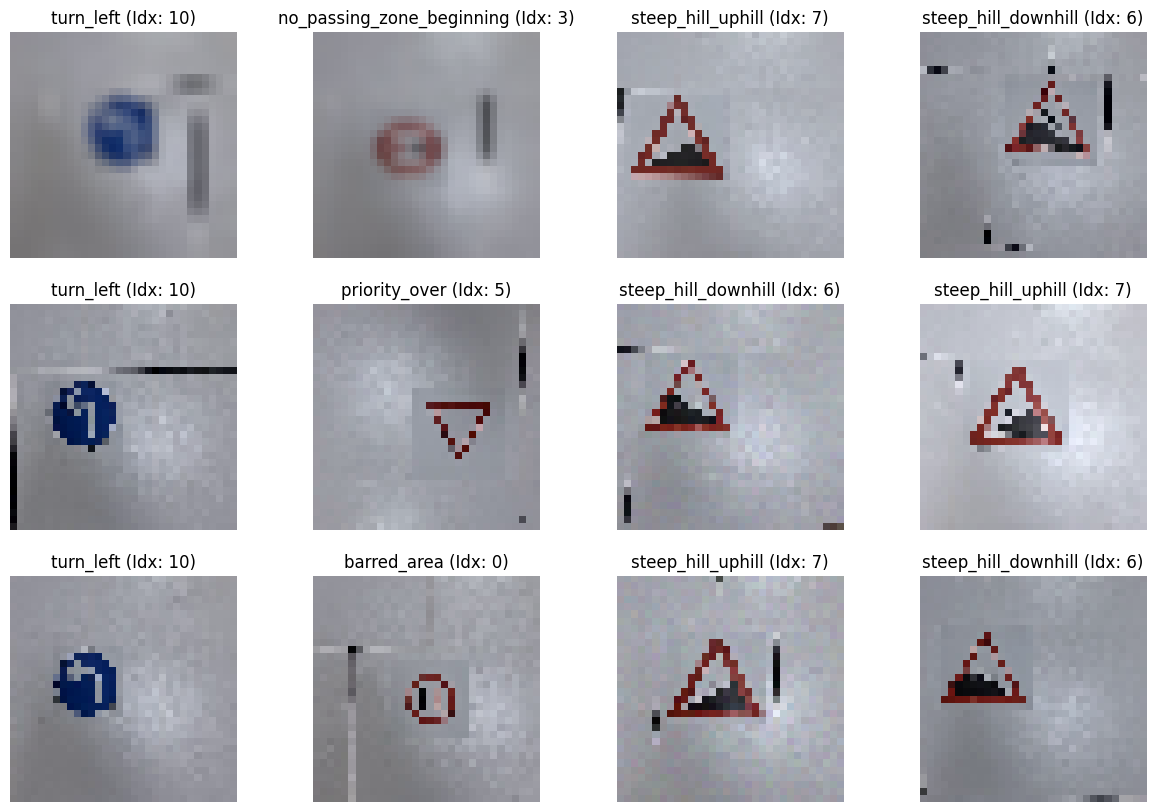

Class Distribution:
barred_area: 3255 samples
cross_walk: 3114 samples
go_straight: 2646 samples
no_passing_zone_beginning: 2990 samples
parking_zone: 2615 samples
priority_over: 3073 samples
steep_hill_downhill: 2355 samples
steep_hill_uphill: 2626 samples
stop: 2953 samples
tunnel_beginning: 3218 samples
turn_left: 3109 samples
turn_right: 2979 samples


In [10]:
train_dataset = TrafficSignDB(
    images_path_list=images_path_list_train,
    labels_path_list=labels_path_list_train,
    transform=transform_simple
)

test_dataset = TrafficSignDB(
    images_path_list=images_path_list_test,
    labels_path_list=labels_path_list_test,
    transform=transform_simple
)

verify_dataset(train_dataset, class_names)

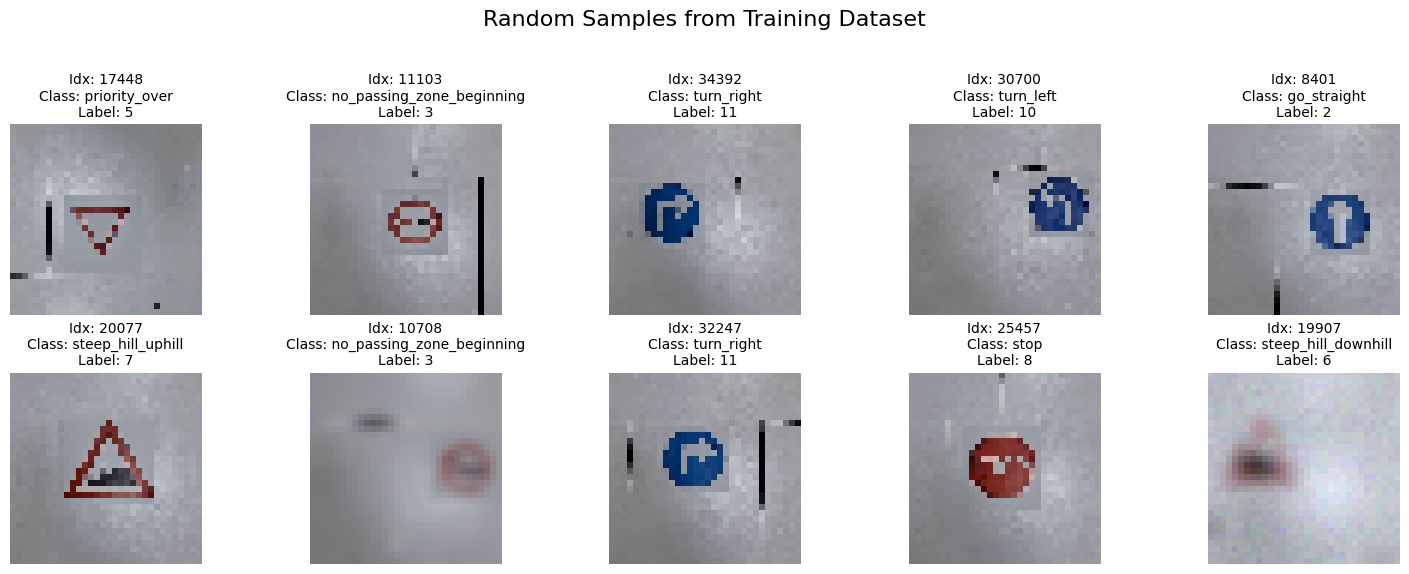

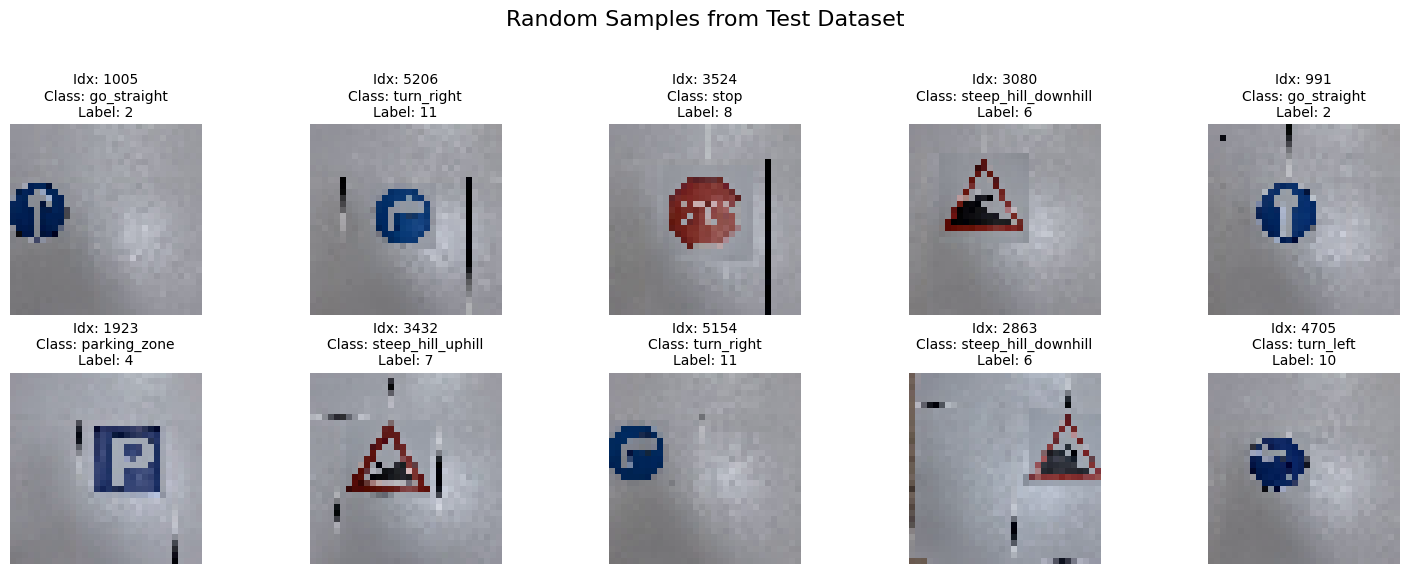

In [11]:
def denormalize_image(image_tensor, mean, std):
    image = image_tensor.cpu().numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    image = image * std + mean
    image = np.clip(image, 0, 1)
    return image

def show_random_samples_subplot(dataset, num_samples=10, dataset_name="Dataset"):
    indices = random.sample(range(len(dataset)), num_samples)
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        class_name = dataset.get_class_name(label)
        if isinstance(image, torch.Tensor):
            image = denormalize_image(image, dataset_mean, dataset_std)
        axes[i].imshow(image)
        axes[i].set_title(f"Idx: {idx}\nClass: {class_name}\nLabel: {label}", fontsize=10)
        axes[i].axis('off')
    
    plt.suptitle(f"Random Samples from {dataset_name}", fontsize=16)
    plt.tight_layout(rect=(0, 0.03, 1, 0.95), w_pad=2)
    plt.show()

show_random_samples_subplot(train_dataset, num_samples=10, dataset_name="Training Dataset")
show_random_samples_subplot(test_dataset, num_samples=10, dataset_name="Test Dataset")

## Training the Model

In [11]:
import time

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchsummary import summary

### Preprocessing

In [12]:
dataset_mean = [0.57121, 0.57445, 0.60535]
dataset_std = [0.11756, 0.12333, 0.11987]
img_resize = 32

In [13]:
def pre_process_image(image):
    image = cv2.resize(image, (img_resize, img_resize), interpolation=cv2.INTER_CUBIC)
    image = image.astype(np.float32) / 255.0
    return image

In [14]:
class TrafficSignDB(Dataset):
    def __init__(self, images_path_list, labels_path_list, transform=None):
        self.images_path_list = images_path_list
        self.labels_path_list = labels_path_list
        self.transform = transform
        self.class_names = sorted(list(set(os.path.basename(os.path.dirname(p)) 
                                         for p in images_path_list)))
        self.idx_to_class = self._create_label_mapping()
        
    def _create_label_mapping(self):
        return {idx: name for idx, name in enumerate(class_names)}
    
    def __len__(self) -> int:
        return len(self.images_path_list)
    
    def __getitem__(self, index):
        path = self.images_path_list[index]
        label = self.labels_path_list[index]
        
        try:
            import cv2
            image = cv2.imread(path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = pre_process_image(image)
            
            from PIL import Image
            image = Image.fromarray((image * 255).astype(np.uint8))
            
            if self.transform:
                image = self.transform(image)
            else:
                image = transforms.ToTensor()(image)
                image = transforms.Normalize(mean=dataset_mean, std=dataset_std)(image)
            
        except Exception as e:
            print(f"Error processing image {path}: {e}")
            image = torch.zeros(3, img_resize, img_resize)
        
        label = self.labels_path_list[index]
        return image, label
    
    def get_class_name(self, label_idx):
        return self.idx_to_class.get(label_idx, "unknown")

In [15]:
root_dir = 'Dataset'
image_paths = []
labels = []
class_names = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
for cls_idx, class_name in enumerate(class_names):
    pattern = os.path.join(root_dir, class_name, "*.png")
    for path in sorted(os.listdir(os.path.join(root_dir, class_name))):
        full_path = os.path.join(root_dir, class_name, path)
        image_paths.append(full_path)
        labels.append(cls_idx)

In [16]:
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, train_size=0.8, random_state=42, stratify=labels
)

In [17]:
augmentation_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomAffine(
        degrees=5,
        translate=(0.1, 0.1),
        shear=3
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean, std=dataset_std)
])

In [18]:
validation_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean, std=dataset_std)
])

In [19]:
train_paths_SS, valid_paths, train_labels_SS, valid_labels = train_test_split(
    train_paths, train_labels, test_size=0.1, random_state=42, stratify=train_labels
)

In [20]:
train_dataset = TrafficSignDB(train_paths_SS, train_labels_SS, transform=augmentation_transform)
valid_dataset = TrafficSignDB(valid_paths, valid_labels, transform=validation_transform)
test_dataset  = TrafficSignDB(test_paths, test_labels, transform=validation_transform)

In [21]:
batch_size = 128

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
    )
valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
    )
test_loader  = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
    )

Class Distribution:
barred_area: 451 samples
cross_walk: 431 samples
go_straight: 366 samples
no_passing_zone_beginning: 414 samples
parking_zone: 363 samples
priority_over: 426 samples
steep_hill_downhill: 327 samples
steep_hill_uphill: 364 samples
stop: 408 samples
tunnel_beginning: 445 samples
turn_left: 430 samples
turn_right: 412 samples


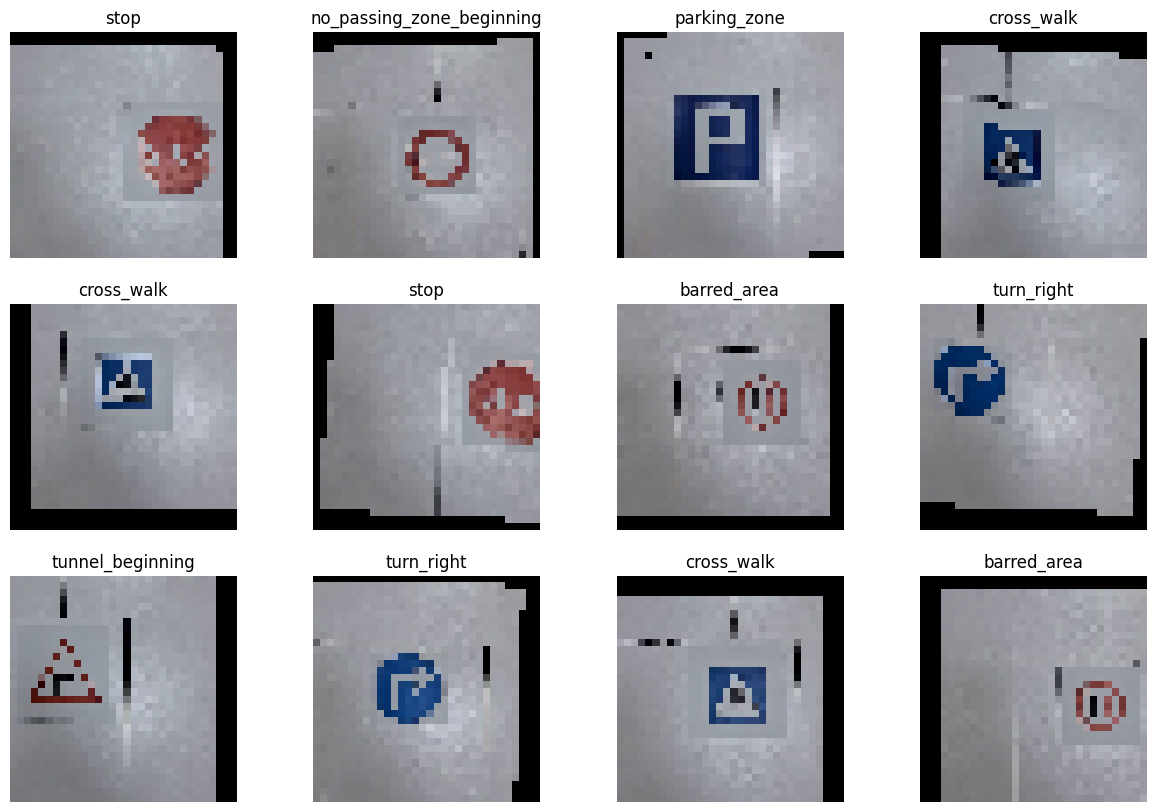

In [22]:
def verify_dataset(dataset, class_names, num_samples=12):
    counts = {i: 0 for i in range(len(class_names))}
    for _, label in dataset:
        counts[label] += 1
    
    print("Class Distribution:")
    for idx, count in counts.items():
        print(f"{class_names[idx]}: {count} samples")
    
    # Visualize random samples
    import random
    indices = random.sample(range(len(dataset)), num_samples)
    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    for ax, idx in zip(axes.flat, indices):
        img, label = dataset[idx]
        # Unnormalize image for display
        mean = np.array(dataset_mean).reshape(1, 1, 3)
        std  = np.array(dataset_std).reshape(1, 1, 3)
        # img is tensor with shape (C, H, W)
        img_disp = img.cpu().permute(1, 2, 0).numpy()
        img_disp = img_disp * std + mean
        ax.imshow(np.clip(img_disp, 0, 1))
        ax.set_title(f"{class_names[label]}")
        ax.axis('off')
    plt.show()

verify_dataset(train_dataset, class_names)


### CNN Model

In [23]:
class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes=12, num_channels=3):
        super().__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(num_channels, 32, 5, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 32, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, 5, padding=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),  # Smaller kernel
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*8*8, 256),  # Proper input size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        return self.classifier(x)

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [25]:
model = TrafficSignCNN(num_classes=12).to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 32, 32, 32]          25,632
              ReLU-4           [-1, 32, 32, 32]               0
         MaxPool2d-5           [-1, 32, 16, 16]               0
           Dropout-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]          51,264
              ReLU-8           [-1, 64, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          36,928
             ReLU-10           [-1, 64, 16, 16]               0
        MaxPool2d-11             [-1, 64, 8, 8]               0
          Dropout-12             [-1, 64, 8, 8]               0
          Flatten-13                 [-1, 4096]               0
           Linear-14                  [

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

In [27]:
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return correct / total

### Training

In [28]:
num_epochs = 15
best_acc = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        running_loss += loss.item()
    
    val_acc = evaluate(model, valid_loader, device)
    avg_loss = running_loss / len(train_loader)
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "traffic_sign_cnn_V02.pth")
    print(f"Epoch {epoch+1}: Loss: {avg_loss:.4f}, Val Acc: {val_acc:.4f}")

print("Final model saved!")
torch.save(model.state_dict(), "traffic_sign_cnn_V02_F.pth")

Epoch 1: Loss: 2.0383, Val Acc: 0.5911
Epoch 2: Loss: 1.1020, Val Acc: 0.8234
Epoch 3: Loss: 0.6394, Val Acc: 0.9089
Epoch 4: Loss: 0.4153, Val Acc: 0.9442
Epoch 5: Loss: 0.2767, Val Acc: 0.9591
Epoch 6: Loss: 0.2085, Val Acc: 0.9981
Epoch 7: Loss: 0.1444, Val Acc: 0.9981
Epoch 8: Loss: 0.1193, Val Acc: 0.9907
Epoch 9: Loss: 0.0991, Val Acc: 0.9944
Epoch 10: Loss: 0.0964, Val Acc: 1.0000
Epoch 11: Loss: 0.0788, Val Acc: 1.0000
Epoch 12: Loss: 0.0756, Val Acc: 1.0000
Epoch 13: Loss: 0.0512, Val Acc: 1.0000
Epoch 14: Loss: 0.0381, Val Acc: 1.0000
Epoch 15: Loss: 0.0355, Val Acc: 1.0000
Final model saved!
